In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import uproot
import awkward as ak
import sys

%matplotlib inline

In [66]:
#data_path = "/dipc/elena/WCTE_2025_commissioning/root_files/data/260MeVc/WCTE_offline_R1574S0_VME1558.root"  #260MeV/c  44 pion-only events

data_path = "/dipc/elena/WCTE_2025_commissioning/root_files/data/WCTE_offline_R1711S0_VME1650.root"   #260MeV/c, 52 pion-only events
                                                                                                    # ~8500 e-only events
mc_path = "/dipc/elena/WCTE_2025_commissioning/root_files/mc/pi+_260MeVc_1000evts_masked.root"
tree ="WCTEReadoutWindows"
n_events = 3000000

data_tree = uproot.open(f"{data_path}:{tree}")
mc_tree = uproot.open(f"{mc_path}:{tree}")


data = data_tree.arrays(entry_stop = n_events, library="ak")
mc = mc_tree.arrays(entry_stop = n_events, library="ak")

In [67]:
print(f"Data events loaded: {len(data['event_number'])}")  
print(f"MC events loaded: {len(mc['event_number'])}")

Data events loaded: 21454
MC events loaded: 3000


In [68]:
for branch in (data.fields):
    print(branch, ak.type(data[branch]))  #if "var", variable number of elements

window_time 21454 * float64
run_id 21454 * int32
sub_run_id 21454 * int32
spill_counter 21454 * int32
event_number 21454 * int32
readout_number 21454 * int32
trigger_types 21454 * var * int32
trigger_times 21454 * var * float64
led_gains 21454 * var * float32
led_dacsettings 21454 * var * float32
led_ids 21454 * var * int32
led_card_ids 21454 * var * int32
led_slot_numbers 21454 * var * int32
led_event_types 21454 * var * int32
led_types 21454 * var * int32
led_sequence_numbers 21454 * var * int32
led_counters 21454 * var * int32
hit_mpmt_card_ids 21454 * var * int32
hit_pmt_channel_ids 21454 * var * int32
hit_mpmt_slot_ids 21454 * var * int32
hit_pmt_position_ids 21454 * var * int32
hit_pmt_charges 21454 * var * float32
hit_pmt_times 21454 * var * float64
pmt_waveform_mpmt_card_ids 21454 * var * int32
pmt_waveform_pmt_channel_ids 21454 * var * int32
pmt_waveform_mpmt_slot_ids 21454 * var * int32
pmt_waveform_pmt_position_ids 21454 * var * int32
pmt_waveform_times 21454 * var * float64

In [72]:
import sys
sys.path.append("/scratch/elena/WCTE_DATA_ANALYSIS/WCTE_2025_commissioning/2025_data/")
import DataQualityNotebooks.VMEAnalysis as VMEAnalysisModule
import importlib
importlib.reload(VMEAnalysisModule) 
from DataQualityNotebooks.VMEAnalysis import VMEAnalysis


config_file = "/scratch/elena/WCTE_DATA_ANALYSIS/WCTE_2025_commissioning/config/lep_v51_config.json"
vme_analysis_cut = {
    "t4_qcut": 300,
    "hc0_cut": 150,
    "hc1_cut": 100,
    "act1_ev": 900,
    "act2_pi": 1800,
    "act2_mu_low": 2000,
    "act2_mu_high": 10000,
    "tdc_cut": 200
}

#extract the interesting variables
qdc_charges = data["beamline_pmt_qdc_charges"]
qdc_ids = data["beamline_pmt_qdc_ids"]
tdc_times = data["beamline_pmt_tdc_times"]
tdc_ids = data["beamline_pmt_tdc_ids"]

#initialize the VMEAnalysis object
vme = VMEAnalysis(config_file, vme_analysis_cut, runNumber=1574)

#load data into the analysis object
q, tdc = vme.load_data(qdc_ids, qdc_charges, tdc_ids, tdc_times)

#apply cuts (mask)
vme.make_cuts_on_data(qdc_ids, qdc_charges, tdc_ids, tdc_times)

#mask for e-only
mu_mask = vme.getEventMask("muon-only")

#apply mask to the awkward array to filter events
data = data[mu_mask]

print(f"Selected {len(data)} muon-like events")     #out of {len(df_data)} total events")

Current Working Directory: /scratch/elena/WCTE_DATA_ANALYSIS/WCTE_MC-Data_Validation_with_GAIN_Calibration
[INFO] Total events: 2601
[INFO] Computing activity sums and TOF values...
[INFO] Applying additional cuts...
[INFO] Defining cut sequences...
[INFO] Converting to NumPy for stats...
[INFO] Gathering statistics per cut set...
Selected 2601 muon-like events


# let's explore the waverforms of Data

In [6]:
for branch in (data.fields):
    if "waveform" in branch.lower():
        print(branch, ak.type(data[branch]))  #if "var", variable number of elements

pmt_waveform_mpmt_card_ids 8524 * var * int32
pmt_waveform_pmt_channel_ids 8524 * var * int32
pmt_waveform_mpmt_slot_ids 8524 * var * int32
pmt_waveform_pmt_position_ids 8524 * var * int32
pmt_waveform_times 8524 * var * float64
pmt_waveforms 8524 * var * var * float64


In [7]:
data_wave = ak.flatten(data["pmt_waveforms"])
print(data_wave)

[[1, 0, 0, 0, 0, 0, 4, 17, 32, 21, ... -13, -11, -10, -7, -6, -8, -9, -9, -6, -5]]


In [8]:
print(data["pmt_waveform_mpmt_card_ids"][0])  # card ids for event 0
print(data["pmt_waveform_pmt_channel_ids"][0])
print(data["pmt_waveform_mpmt_slot_ids"][0])
print(data["pmt_waveform_pmt_position_ids"][0])
print(data["pmt_waveform_times"][0])
print(data["pmt_waveforms"][0])

[10, 132, 132, 132, 132, 132, 25, 25, 25, ... 130, 130, 130, 130, 130, 130, 130, 130]
[12, 17, 18, 6, 15, 19, 2, 7, 14, 13, 6, 7, ... 0, 2, 3, 5, 19, 14, 15, 13, 16, 2, 7]
[61, -1, -1, -1, -1, -1, 62, 62, 62, 29, ... -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
[4, -2, -2, -2, -2, -2, 0, 2, 13, 12, 8, ... -2, -2, -2, -2, -2, -2, -2, -2, -2, -2]
[1.67e+03, 2.17e+03, 2.17e+03, 2.19e+03, ... 2.43e+03, 2.43e+03, 2.97e+03, 3.56e+03]
[[1, 0, 0, 0, 0, 0, 4, 17, 32, 21, ... -8, -5, -4, -6, -9, -12, -13, -10, -9, -11]]


In [9]:
event_index = 0

card_ids = data["pmt_waveform_mpmt_card_ids"][event_index]
slot_ids = data["pmt_waveform_mpmt_slot_ids"][event_index]
channel_ids = data["pmt_waveform_pmt_channel_ids"][event_index]
position_ids = data["pmt_waveform_pmt_position_ids"][event_index]
times = data["pmt_waveform_times"][event_index]
waveforms = data["pmt_waveforms"][event_index]

#mask to discard card_id > 120 and slot_id = -1
mask = [(c < 120) and (s != -1) for c, s in zip(card_ids, slot_ids)]

#apply mask to filter all arrays
filtered_card_ids = [c for c, keep in zip(card_ids, mask) if keep]
filtered_slot_ids = [s for s, keep in zip(slot_ids, mask) if keep]
filtered_channel_ids = [ch for ch, keep in zip(channel_ids, mask) if keep]
filtered_position_ids = [p for p, keep in zip(position_ids, mask) if keep]
filtered_times = [t for t, keep in zip(times, mask) if keep]
filtered_waveforms = [wf for wf, keep in zip(waveforms, mask) if keep]

print("Original number of waveforms:", len(card_ids))
print("Filtered number of waveforms:", len(filtered_card_ids))

Original number of waveforms: 712
Filtered number of waveforms: 681


In [10]:
original_waves = []
filtered_waves = []

#containers to store filtered data
filtered_data = {
    "card_ids": [],
    "slot_ids": [],
    "channel_ids": [],
    "position_ids": [],
    "times": [],
    "waveforms": []
}

for event_index in range(len(data)):
    card_ids = data["pmt_waveform_mpmt_card_ids"][event_index]
    slot_ids = data["pmt_waveform_mpmt_slot_ids"][event_index]
    channel_ids = data["pmt_waveform_pmt_channel_ids"][event_index]
    position_ids = data["pmt_waveform_pmt_position_ids"][event_index]
    times = data["pmt_waveform_times"][event_index]
    waveforms = data["pmt_waveforms"][event_index]
    
    original_waves.append(len(card_ids))
    

    mask = [(c < 120) and (s != -1) for c, s in zip(card_ids, slot_ids)]
    

    filtered_waves.append(sum(mask))
    
 
    filtered_data["card_ids"].append([c for c, keep in zip(card_ids, mask) if keep])
    filtered_data["slot_ids"].append([s for s, keep in zip(slot_ids, mask) if keep])
    filtered_data["channel_ids"].append([ch for ch, keep in zip(channel_ids, mask) if keep])
    filtered_data["position_ids"].append([p for p, keep in zip(position_ids, mask) if keep])
    filtered_data["times"].append([t for t, keep in zip(times, mask) if keep])
    filtered_data["waveforms"].append([wf for wf, keep in zip(waveforms, mask) if keep])


#df to display the filtering 
df_waves = pd.DataFrame({
    "original_waveforms": original_waves,
    "filtered_waveforms": filtered_waves
})

print(df_waves)

      original_waveforms  filtered_waveforms
0                    712                 681
1                    734                 698
2                    668                 632
3                    852                 816
4                    831                 783
...                  ...                 ...
8519                 784                 740
8520                 733                 699
8521                 796                 763
8522                 491                 451
8523                 348                 313

[8524 rows x 2 columns]


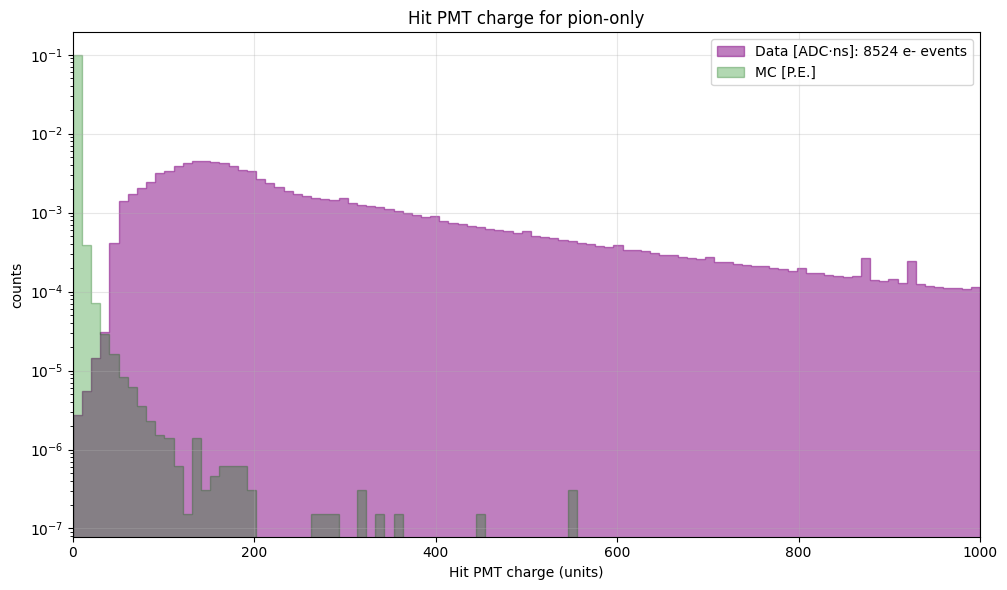

In [11]:
data_charges = ak.flatten(data["hit_pmt_charges"])
mc_charges   = ak.flatten(mc["hit_pmt_charges"])

min_range_charge = 0
max_range_charge = 1000

data_charges = data_charges[(data_charges >= min_range_charge) & (data_charges <= max_range_charge)]
mc_charges   = mc_charges[(mc_charges >= min_range_charge) & (mc_charges <= max_range_charge)]

bins = np.linspace(min_range_charge, max_range_charge, 100)

plt.figure(figsize=(10, 6))

# --- Histograms with edgecolor ---
plt.hist(data_charges, bins=bins, alpha=0.5, color='purple',
         label=f'Data [ADC·ns]: {len(data)} e- events',
         histtype='stepfilled', density=True, edgecolor='purple')
plt.hist(mc_charges, bins=bins, alpha=0.3, color='green',
         label='MC [P.E.]',
         histtype='stepfilled', density=True, edgecolor='darkgreen')

plt.yscale('log')
plt.xlabel('Hit PMT charge (units)')
plt.ylabel('counts')
plt.title('Hit PMT charge for pion-only')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.xlim(min_range_charge, max_range_charge)
plt.show()

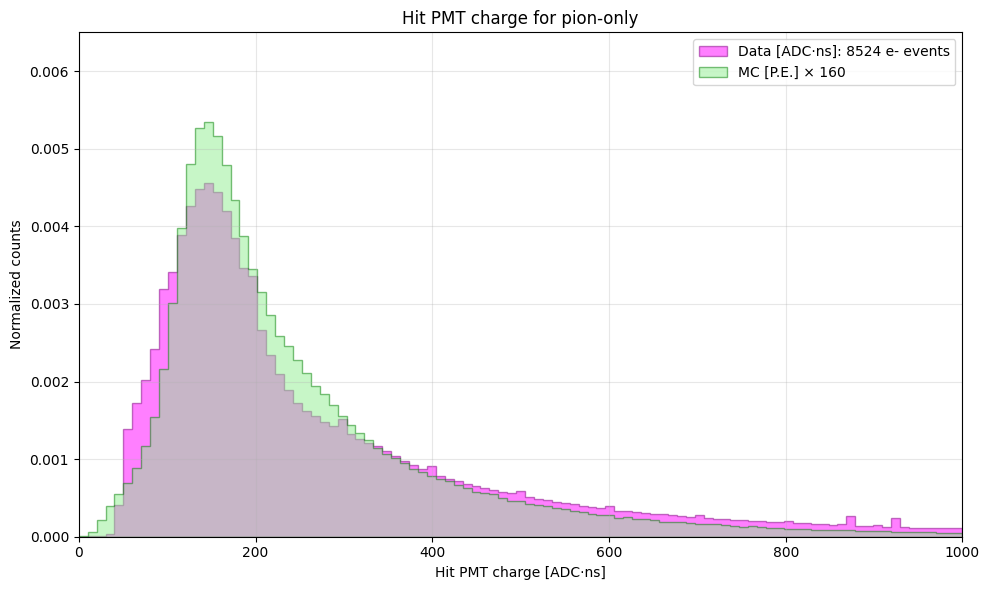

In [12]:
#flatten charges
data_charges = ak.to_numpy(ak.flatten(data["hit_pmt_charges"]))
mc_charges   = ak.to_numpy(ak.flatten(mc["hit_pmt_charges"])) * 160  # scale factor

#apply charge cuts
min_range_charge = 0
max_range_charge = 1000

data_charges = data_charges[(data_charges >= min_range_charge) & (data_charges <= max_range_charge)]
mc_charges   = mc_charges[(mc_charges >= min_range_charge) & (mc_charges <= max_range_charge)]


bins = np.linspace(min_range_charge, max_range_charge, 100)

plt.figure(figsize=(10, 6))
#data
plt.hist(data_charges, bins=bins, alpha=0.5, color='magenta',
         label=f'Data [ADC·ns]: {len(data)} e- events',
         histtype='stepfilled', density=True, edgecolor='purple')
#MC
plt.hist(mc_charges, bins=bins, alpha=0.5, color='lightgreen',
         label='MC [P.E.] × 160',
         histtype='stepfilled', density=True, edgecolor='green')

plt.xlabel('Hit PMT charge [ADC·ns]')
plt.ylabel('Normalized counts')
plt.title('Hit PMT charge for pion-only')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(min_range_charge, max_range_charge)
plt.ylim(0, 0.0065)
plt.yticks(np.linspace(0, 0.006, 7))  #0.0, 0.001, ..., 0.006
plt.tight_layout()
plt.show()

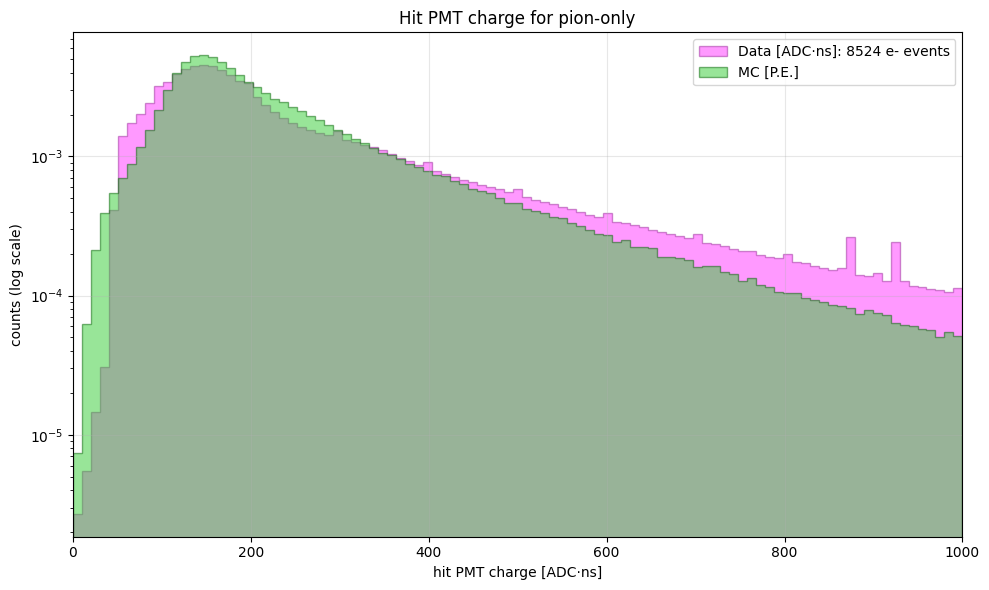

In [13]:
#usamos los mismos data_charges y mc_charges filtrados pion-only
#data_charges ya filtrado
#mc_charges raw ya filtrado
mc_charges_scaled = mc_charges * 160  # scale factor

min_range_charge = 0
max_range_charge = 1000
bins = np.linspace(min_range_charge, max_range_charge, 100)

#plot MC no escalado
plt.figure(figsize=(10, 6))
plt.hist(data_charges, bins=bins, alpha=0.4, color='magenta',
         label=f'Data [ADC·ns]: {len(data)} e- events',
         histtype='stepfilled', density=True, edgecolor='purple')
plt.hist(mc_charges, bins=bins, alpha=0.5, color='limegreen',
         label='MC [P.E.]',
         histtype='stepfilled', density=True, edgecolor='darkgreen')
plt.yscale('log')
plt.xlabel('hit PMT charge [ADC·ns]')
plt.ylabel('counts (log scale)')
plt.title('Hit PMT charge for pion-only')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(min_range_charge, max_range_charge)
plt.tight_layout()
plt.show()

In [14]:
print(mc.fields)

['event_number', 'window_time', 'run_id', 'sub_run_id', 'spill_counter', 'readout_number', 'hit_mpmt_card_ids', 'hit_pmt_channel_ids', 'hit_mpmt_slot_ids', 'hit_pmt_position_ids', 'hit_pmt_charges', 'hit_pmt_times', 'trigger_types', 'trigger_times', 'led_gains', 'led_dacsettings', 'led_ids', 'led_card_ids', 'led_slot_numbers', 'led_event_types', 'led_types', 'led_sequence_numbers', 'led_counters', 'beamline_pmt_qdc_charges', 'beamline_pmt_qdc_ids', 'beamline_pmt_tdc_times', 'beamline_pmt_tdc_ids']


In [58]:
npz_dir = "/scratch/elena/WCTE_DATA_ANALYSIS/WCTE_2025_commissioning/2025_data/WCTE_BRB_Data_Analysis/"
n_chunks = 15
gain_file = [f"{npz_dir}pmt_charge_fit_results_doubleGauss_{i}_[-4,1].npz" for i in range(0, n_chunks+1)]

data_list = []
for f in gain_file:
    arr = np.load(f, allow_pickle=True)["results"]
    data_list.append(arr)


data_array = np.concatenate(data_list)


wcte_event_display_path = "/scratch/elena/WCTE_DATA_ANALYSIS/WCTE_2025_commissioning/2025_data/WCTE_event_display"
sys.path.append(wcte_event_display_path)
from EventDisplay import EventDisplay

#mapping with EventDisplay
ed = EventDisplay()
ed.load_mPMT_positions("mPMT_2D_projection_angles.csv")


gain_per_channel = np.full(ed.nChannels, np.nan)
for i in range(len(data_array)):
    slot  = data_array['slot_id'][i]
    ch    = data_array['channel_id'][i]
    gain  = data_array['gain'][i]
    idx = 19 * slot + ch
    if idx < ed.nChannels:
        gain_per_channel[idx] = gain


mc_charges = ak.flatten(mc["hit_pmt_charges"])
mc_slot_ids = ak.flatten(mc["hit_mpmt_slot_ids"])
mc_channel_ids = ak.flatten(mc["hit_pmt_channel_ids"])


mask = mc_slot_ids != -1
mc_charges     = mc_charges[mask]
mc_slot_ids    = mc_slot_ids[mask]
mc_channel_ids = mc_channel_ids[mask]


mc_charges     = ak.to_numpy(mc_charges)
mc_slot_ids    = ak.to_numpy(mc_slot_ids)
mc_channel_ids = ak.to_numpy(mc_channel_ids)


data_charges = ak.to_numpy(ak.flatten(data["hit_pmt_charges"]))
data_slot_ids = ak.to_numpy(ak.flatten(data["hit_mpmt_slot_ids"]))
data_channel_ids = ak.to_numpy(ak.flatten(data["hit_pmt_channel_ids"]))

#ADC·ns --> P.E.
data_idx = 19 * data_slot_ids + data_channel_ids
data_charges_pe = data_charges / gain_per_channel[data_idx]


min_range_charge = 0
max_range_charge = 15

data_charges_pe = data_charges_pe[(data_charges_pe >= min_range_charge) & (data_charges_pe <= max_range_charge)]
mc_charges = mc_charges[(mc_charges >= min_range_charge) & (mc_charges <= max_range_charge)]

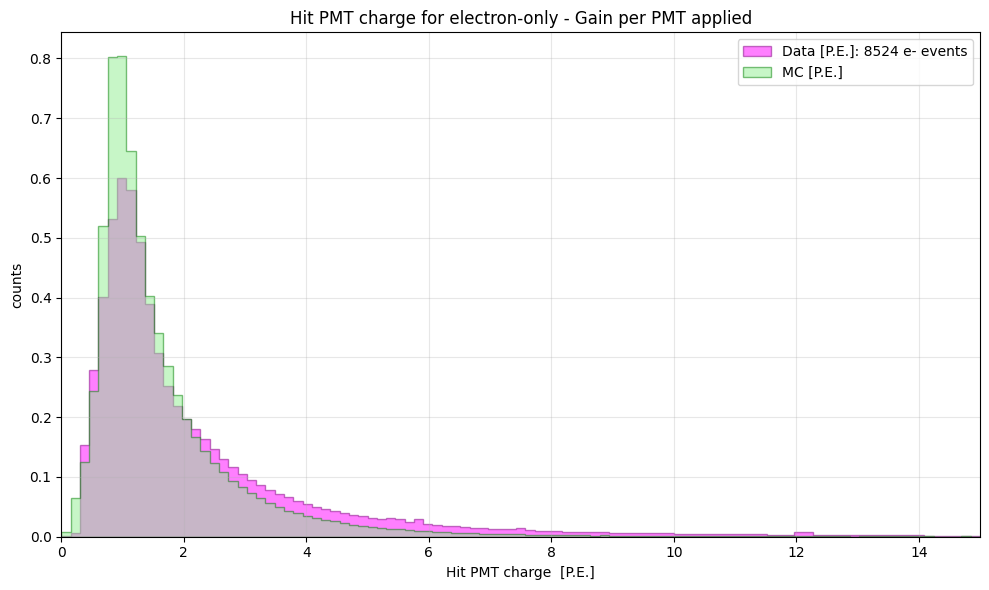

In [59]:
#plot data/MC aplicando el gain per PMT
bins = np.linspace(min_range_charge, max_range_charge, 100)

plt.figure(figsize=(10, 6))
plt.hist(data_charges_pe, bins=bins, alpha=0.5, color='magenta', label=f'Data [P.E.]: {len(data)} e- events', 
         histtype='stepfilled', density=True, edgecolor='purple')
plt.hist(mc_charges, bins=bins, alpha=0.5, color='lightgreen', label='MC [P.E.]',
         histtype='stepfilled', density = True, edgecolor='green')

#plt.yscale("log")
plt.xlabel('Hit PMT charge  [P.E.]')
plt.ylabel('counts')
plt.title('Hit PMT charge for electron-only - Gain per PMT applied')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.xlim(min_range_charge, max_range_charge)
plt.show()

Aquí estás tomando todos los hits individuales de todos los PMTs y eventos y los “aplanas” en un solo arreglo.

Cada “hit” = la carga que un PMT individual registró en un evento específico.

No estás seleccionando un único hit: estás usando todos los hits de todos los eventos y PMTs.

Resultado: el histograma muestra la distribución de carga por hit, no por evento.

🔑 Es micro: cada barra dice “cuántos hits tienen esta carga” sin importar a qué evento o PMT pertenecen.

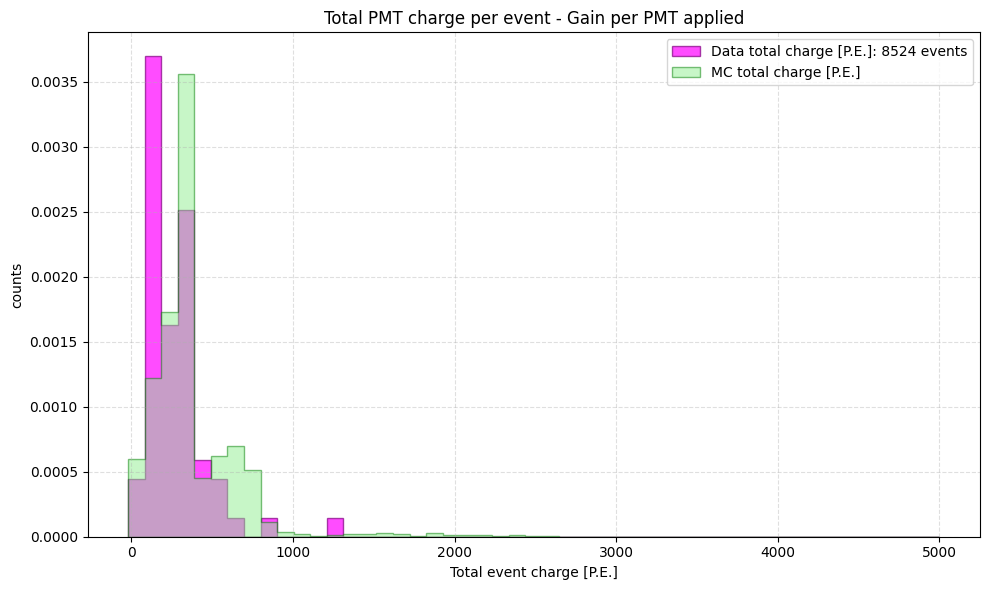

In [62]:
# -----------------------------------------------------------
# Compute total charge per event for data
# -----------------------------------------------------------
data_total_charges = []
for event_charges, event_slots, event_channels in zip(data["hit_pmt_charges"],
                                                      data["hit_mpmt_slot_ids"],
                                                      data["hit_pmt_channel_ids"]):
    event_charges = ak.to_numpy(event_charges)
    event_slots   = ak.to_numpy(event_slots)
    event_channels= ak.to_numpy(event_channels)
    idx = 19*event_slots + event_channels
    event_charges_pe = event_charges / gain_per_channel[idx]
    data_total_charges.append(np.sum(event_charges_pe))
data_total_charges = np.array(data_total_charges)

# -----------------------------------------------------------
# Compute total charge per event for MC
# -----------------------------------------------------------
mc_total_charges = ak.to_numpy(ak.sum(mc["hit_pmt_charges"], axis=-1))  # sum over PMTs per event

# -----------------------------------------------------------
# Plot total charge per event (data vs MC)
# -----------------------------------------------------------
bins = np.linspace(-20, 5000, 50)

plt.figure(figsize=(10,6))
plt.hist(data_total_charges, bins=bins, alpha=0.7, color='magenta', 
         label=f'Data total charge [P.E.]: {len(data_total_charges)} events',
         histtype='stepfilled', edgecolor='purple', density=True)
plt.hist(mc_total_charges, bins=bins, alpha=0.5, color='lightgreen', 
         label=f'MC total charge [P.E.]', histtype='stepfilled', edgecolor='green', density=True)

plt.xlabel('Total event charge [P.E.]')
plt.ylabel('counts')
plt.title('Total PMT charge per event - Gain per PMT applied')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

Para cada evento, sumas la carga de todos los PMTs activados en ese evento.

Resultado: un número por evento = “total P.E. del evento”.

Histograma: cada barra representa la cantidad de eventos que tuvieron esa carga total.

🔑 Es macro: te dice la energía total de cada evento, no importa cuántos PMTs contribuyeron, ni cuál fue el valor de cada uno.

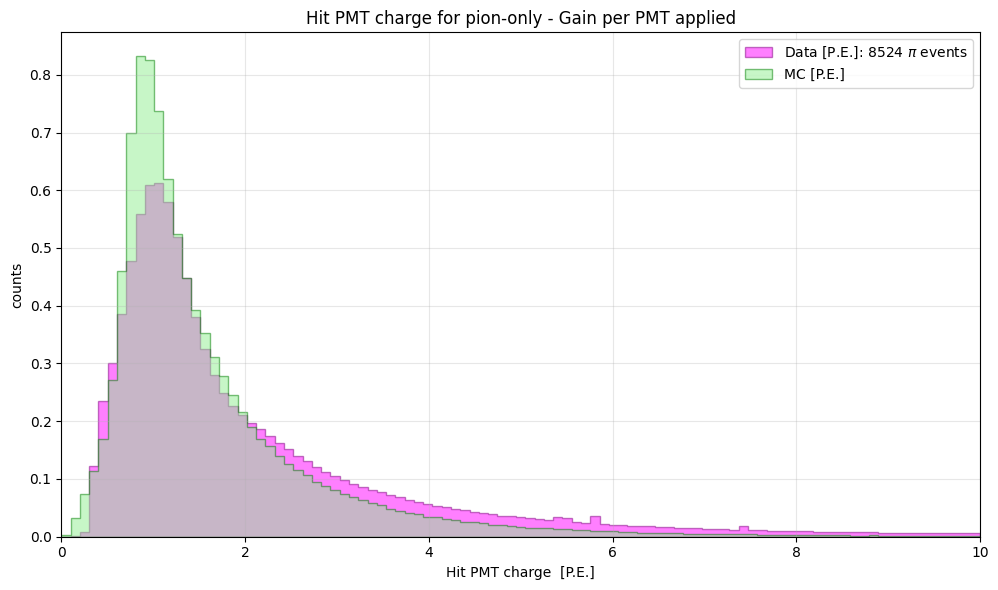

In [17]:
#same as before but MC wighted to MC number of events
mc_weights = np.ones_like(mc_charges)*(len(data_charges_pe) / len(mc_charges))

bins = np.linspace(min_range_charge, 10, 100)

plt.figure(figsize=(10, 6))
plt.hist(data_charges_pe, bins=bins, alpha=0.5, color='magenta', label=f'Data [P.E.]: {len(data)} $\pi$ events', 
         histtype='stepfilled', density=True, edgecolor='purple')
plt.hist(mc_charges, bins=bins, alpha=0.5, color='lightgreen', label='MC [P.E.]',  weights=mc_weights,
         histtype='stepfilled', density = True, edgecolor='green')

#plt.yscale("log")
plt.xlabel('Hit PMT charge  [P.E.]')
plt.ylabel('counts')
plt.title('Hit PMT charge for pion-only - Gain per PMT applied')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.xlim(min_range_charge, 10)
plt.show()

/dipc/elena/.local/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


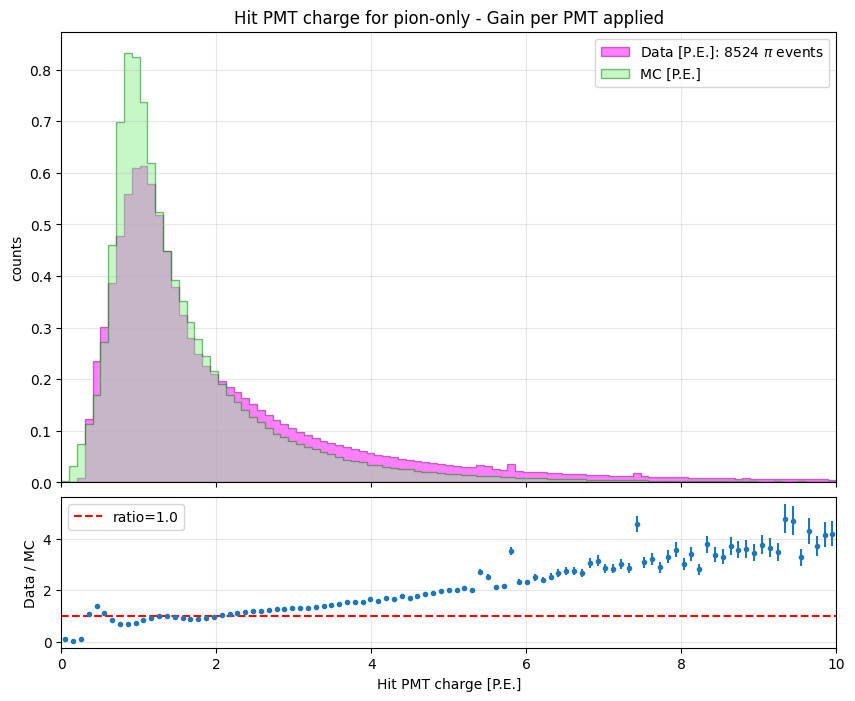

In [18]:
lo = min(np.min(data_charges_pe), np.min(mc_charges), min_range_charge)
hi = 10
bins = np.linspace(lo, hi, 100)

#Histogram **counts** --> so statistics are meaningful
data_counts, _ = np.histogram(data_charges_pe, bins=bins)
mc_counts, _   = np.histogram(mc_charges, bins=bins, weights=mc_weights)

#for weighted MC, variance is sum of w^2 per bin
mc_w2, _       = np.histogram(mc_charges, bins=bins, weights=mc_weights**2)

#only take ratio where both sides have entries
valid = (mc_counts > 0) & (data_counts > 0)


ratio = np.full_like(mc_counts, np.nan, dtype=float)
ratio[valid] = data_counts[valid] / mc_counts[valid]

data_err = np.sqrt(data_counts.astype(float))
mc_err   = np.sqrt(mc_w2)
ratio_err = np.full_like(ratio, np.nan, dtype=float)
ratio_err[valid] = ratio[valid] * np.sqrt((data_err[valid]/data_counts[valid])**2 + (mc_err[valid]/mc_counts[valid])**2)


bin_centers = 0.5*(bins[:-1] + bins[1:])
plt.figure(figsize=(10,8))
gs = plt.GridSpec(2,1, height_ratios=[3,1], hspace=0.05)

ax = plt.subplot(gs[0])
ax.hist(data_charges_pe, bins=bins, alpha=0.5, color='magenta', label=f'Data [P.E.]: {len(data)} $\\pi$ events', 
        histtype='stepfilled', density=True, edgecolor='purple')
ax.hist(mc_charges, bins=bins, alpha=0.5, color='lightgreen', label='MC [P.E.]', weights=mc_weights,
        histtype='stepfilled', density=True, edgecolor='green')
ax.set_ylabel('counts')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(lo, hi)
ax.set_title('Hit PMT charge for pion-only - Gain per PMT applied')

#ratio plot
axr = plt.subplot(gs[1], sharex=ax)
axr.errorbar(bin_centers[valid], ratio[valid], yerr=ratio_err[valid], fmt='o', ms=3)
axr.axhline(1.0, color='red', linestyle='--', label="ratio=1.0")
axr.legend()
axr.set_xlabel('Hit PMT charge [P.E.]')
axr.set_ylabel('Data / MC')
axr.grid(True, alpha=0.3)
plt.setp(ax.get_xticklabels(), visible=False)  # hide top x labels
plt.tight_layout()
plt.show()


In [19]:
type(data)

awkward.highlevel.Array

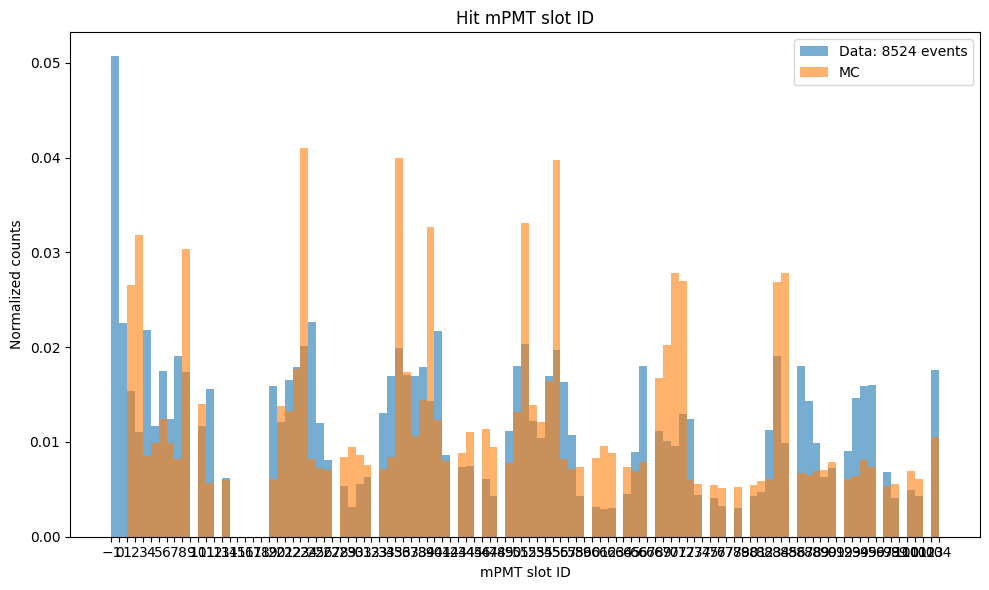

In [20]:
#mPMT slot ids

data_slots = ak.flatten(data["hit_mpmt_slot_ids"])
mc_slots = ak.flatten(mc["hit_mpmt_slot_ids"])

min_slot = int(min(ak.min(data_slots), ak.min(mc_slots)))
max_slot = int(max(ak.max(data_slots), ak.max(mc_slots)))

bins = np.arange(min_slot, max_slot, 1) 

plt.figure(figsize=(10, 6))
plt.hist(data_slots, bins=bins, alpha=0.6, label=f'Data: {len(data)} events', histtype='stepfilled', density=True)
plt.hist(mc_slots, bins=bins, alpha=0.6, label='MC', histtype='stepfilled', density=True)

plt.xlabel('mPMT slot ID')
plt.ylabel('Normalized counts')
plt.title('Hit mPMT slot ID')
plt.legend()
plt.tight_layout()
plt.xticks(np.arange(min_slot, max_slot))  

plt.show()

- We want slot_ids vs. charge (not only vs counts)

- Let's identify and separate PMT ids

In [21]:
#convert 1D flatten arrays into Numpy arrays
data_slots = ak.to_numpy(ak.flatten(data["hit_mpmt_slot_ids"]))
data_charges = ak.to_numpy(ak.flatten(data["hit_pmt_charges"]))     #data_charges = ak.flatten(data["hit_pmt_charges"])
data_channels = ak.to_numpy(ak.flatten(data["hit_pmt_channel_ids"]))
data_positions = ak.to_numpy(ak.flatten(data["hit_pmt_position_ids"]))

mc_slots = ak.to_numpy(ak.flatten(mc["hit_mpmt_slot_ids"]))
mc_charges = ak.to_numpy(ak.flatten(mc["hit_pmt_charges"]))
mc_channels = ak.to_numpy(ak.flatten(mc["hit_pmt_channel_ids"]))
mc_positions = ak.to_numpy(ak.flatten(mc["hit_pmt_position_ids"]))


#aligning slot_id and charge pairs correctly with zip
valid_data = [
    (slot, charge, channel, position)
    for slot_list, charge_list, channel_list, pos_list in zip(
        data["hit_mpmt_slot_ids"],
        data["hit_pmt_charges"],
        data["hit_pmt_channel_ids"],
        data["hit_pmt_position_ids"]
    )
    for slot, charge, channel, position in zip(slot_list, charge_list, channel_list, pos_list)
    if slot != -1  
]

valid_mc = [
    (slot, charge, channel, position)
    for slot_list, charge_list, channel_list, pos_list in zip(
        mc["hit_mpmt_slot_ids"],
        mc["hit_pmt_charges"],
        mc["hit_pmt_channel_ids"],
        mc["hit_pmt_position_ids"]
    )
    for slot, charge, channel, position in zip(slot_list, charge_list, channel_list, pos_list)
]


#unpack en arrays alineados
data_slots, data_charges, data_channels, data_positions = zip(*valid_data)
data_slots = np.array(data_slots)
data_charges = np.array(data_charges)
data_channels = np.array(data_channels)
data_positions = np.array(data_positions)
data_pmt_ids = 19 * data_slots + data_positions     #and compute pmt_ids - we identify each PMT ID across all slots

mc_slots, mc_charges, mc_channels, mc_positions = zip(*valid_mc)
mc_slots = np.array(mc_slots)
mc_charges = np.array(mc_charges)
mc_channels = np.array(mc_channels)
mc_positions = np.array(mc_positions)
mc_pmt_ids = 19 * mc_slots + mc_positions

print("data_slot", data_slots)
print(max(data_slots))
print("mc_slot", mc_slots)
print(max(mc_slots))

print(len(data_slots))
print(len(mc_slots))

data_slot [61 62 62 ... 35 35 35]
105
mc_slot [105  30   8 ...  31  40  26]
105
6626111
555445


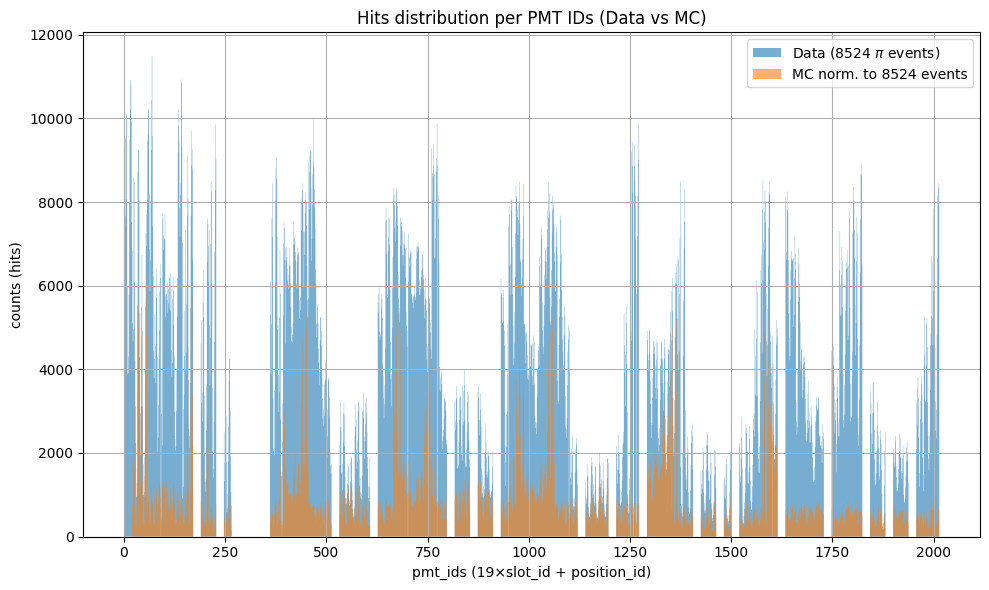

In [22]:
plt.figure(figsize=(10, 6))

max_id = max(data_pmt_ids.max(), mc_pmt_ids.max())
bins = range(0, max_id + 2)
weights = np.ones_like(mc_pmt_ids)*len(data) / len(mc)   #we normalize MC to Data since Data is "true" and we are checking how well MC reproduces Data

plt.hist(data_pmt_ids, bins=bins, alpha=0.6, label=f"Data ({len(data)} $\pi$ events)", histtype='stepfilled')
plt.hist(mc_pmt_ids, bins=bins, alpha=0.6, label=f"MC norm. to {len(data)} events", weights=weights, histtype='stepfilled')

plt.xlabel("pmt_ids (19×slot_id + position_id)")
plt.ylabel(f"counts (hits)")
plt.title("Hits distribution per PMT IDs (Data vs MC)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
sorted_data_ids = sorted(data_pmt_ids)
sorted_mc_ids = sorted(mc_pmt_ids)

print("First 10 sorted Data PMT IDs:", sorted_data_ids[:10])
print("First 10 sorted MC PMT IDs:", sorted_mc_ids[:10])


data_pmt_ids = 19 * data_slots + data_positions
print(data_pmt_ids)


First 10 sorted Data PMT IDs: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
First 10 sorted MC PMT IDs: [19, 19, 19, 19, 19, 19, 19, 19, 19, 19]
[1163 1178 1180 ...  677  680  681]


In [24]:
df_data = pd.DataFrame({'slot': data_slots, 'charge': data_charges})
df_mc = pd.DataFrame({'slot': mc_slots, 'charge': mc_charges})


mean_data = df_data.groupby("slot")["charge"].mean()   #we group those hits that belong to the same slot
mean_mc = df_mc.groupby("slot")["charge"].mean()         #and then we calculate the charge mean (<Q>) of those hits per slot


#resultado: pandas.Series (una sola columna con índice)
#hemos agrupado el df (df_data) por la columna "slot"


# Crear DataFrame conjunto where each row is an slot_id
scale_factors = pd.DataFrame({"mean_charge_data": mean_data, "mean_charge_mc": mean_mc})
scale_factors["scale_factor"] = scale_factors["mean_charge_data"] / scale_factors["mean_charge_mc"]   #adding the "scale_factor" column
print(scale_factors)


average_scale_factor = scale_factors["scale_factor"].mean()
print(f"The average scale factor is", average_scale_factor)

      mean_charge_data  mean_charge_mc  scale_factor
slot                                                
0           663.713779             NaN           NaN
1           392.316651        1.871882    209.584099
2           267.097989        1.937596    137.850168
3           559.863334        1.932501    289.709235
4           269.290508        2.225001    121.029371
...                ...             ...           ...
100         183.060779        1.916794     95.503649
101         180.852090        1.963779     92.093921
103         229.585357        1.542621    148.828075
104         255.133106        1.507790    169.209944
105         319.659434        1.448979    220.610057

[83 rows x 3 columns]
The average scale factor is 152.51132018027798


In [25]:
print("slots in data:", len((data_slots)))
print("slots in MC:", len((mc_slots)))
print("slots in scale_factors:", len(scale_factors))

print("-------------------------------------------")

print("length mc_data", len((mc_charges)))

slots in data: 6626111
slots in MC: 555445
slots in scale_factors: 83
-------------------------------------------
length mc_data 555445


# averaged scale factor applied

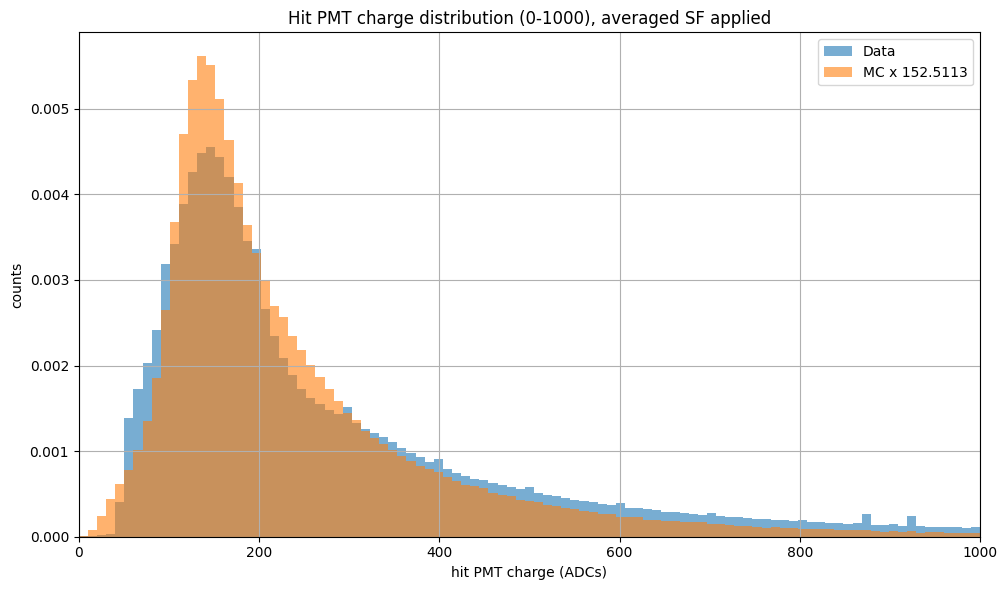

In [26]:
data_charges = ak.flatten(data["hit_pmt_charges"])
mc_charges = ak.flatten(mc["hit_pmt_charges"]) * average_scale_factor  #scale factor

min_range_charge = 0
max_range_charge = 1000

data_charges = data_charges[(data_charges >= min_range_charge) & (data_charges <= max_range_charge)]
mc_charges = mc_charges[(mc_charges >= min_range_charge) & (mc_charges <= max_range_charge)]

bins = np.linspace(min_range_charge, max_range_charge, 100)

plt.figure(figsize=(10, 6))
plt.hist(data_charges, bins=bins, alpha=0.6, label=f'Data', histtype='stepfilled', density=True)
plt.hist(mc_charges, bins=bins, alpha=0.6, label=f'MC x {average_scale_factor:.4f}', histtype='stepfilled', density=True)

plt.xlabel('hit PMT charge (ADCs)')
plt.ylabel('counts')
plt.title('Hit PMT charge distribution (0-1000), averaged SF applied')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xlim(min_range_charge, max_range_charge)

plt.show()

# now calculate the scale factor per slot id and plot it